In [32]:
import matplotlib.pyplot as plt
import tensorflow as tf
from imutils import paths
import os
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout,Flatten,Dense,Input
from keras import Sequential
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from scipy.constants import lb
import numpy as np
import cv2 as cv

In [12]:
def matchTemplatePrivate(img):
    METHOD = cv.TM_CCOEFF

    # lê novamente a imagem para evitar dados quebrados
    edged_img = cv.adaptiveThreshold(img, 255,
                                     cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY_INV, 21, 10)

    img2 = img.copy()

    # carrega template para joelho esquerdo e direito
    template_l = cv.imread("../templates/template_L.png", 0)
    template_r = cv.imread("../templates/template_R.png", 0)

    # encontra contornos
    edged_template_l = cv.adaptiveThreshold(template_r, 255,
                                            cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY_INV, 21, 10)

    edged_template_r = cv.adaptiveThreshold(template_l, 255,
                                            cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY_INV, 21, 10)

    w_l, h_l = template_l.shape[::-1]
    w_r, h_r = template_l.shape[::-1]

    # aplica o math template em ambas as imagens de template
    res_l = cv.matchTemplate(edged_img, edged_template_l, METHOD)
    res_r = cv.matchTemplate(edged_img, edged_template_r, METHOD)

    min_val_l, max_val_l, min_loc_l, max_loc_l = cv.minMaxLoc(res_l)
    min_val_r, max_val_r, min_loc_r, max_loc_r = cv.minMaxLoc(res_r)

    # define qual imagem deu melhor match
    if max_val_r > max_val_l:
        top_left = max_loc_r
        bottom_right = (top_left[0] + w_r, top_left[1] + h_r)
    else:
        top_left = max_loc_l
        bottom_right = (top_left[0] + w_l, top_left[1] + h_l)

    return top_left, bottom_right

In [13]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [14]:
train_dataset = "C:\\Users\\T-GAMER\\Downloads\\KneeXrayData\\KneeXrayData\\ClsKLData\\kneeKL224\\train_preprocessed"
val_dataset = "C:\\Users\\T-GAMER\\Downloads\\KneeXrayData\\KneeXrayData\\ClsKLData\\kneeKL224\\val_preprocessed"
test_dataset = "C:\\Users\\T-GAMER\\Downloads\\KneeXrayData\\KneeXrayData\\ClsKLData\\kneeKL224\\test_preprocessed"

In [15]:
train_images=list(paths.list_images(train_dataset))
val_images=list(paths.list_images(val_dataset))
test_images=list(paths.list_images(test_dataset))

In [ ]:
print(train_images)

In [6]:
print(test_images)

['C:\\Users\\T-GAMER\\Downloads\\KneeXrayData\\KneeXrayData\\ClsKLData\\kneeKL224\\test\\0\\9003175L.png', 'C:\\Users\\T-GAMER\\Downloads\\KneeXrayData\\KneeXrayData\\ClsKLData\\kneeKL224\\test\\0\\9003175R.png', 'C:\\Users\\T-GAMER\\Downloads\\KneeXrayData\\KneeXrayData\\ClsKLData\\kneeKL224\\test\\0\\9003316L.png', 'C:\\Users\\T-GAMER\\Downloads\\KneeXrayData\\KneeXrayData\\ClsKLData\\kneeKL224\\test\\0\\9003815L.png', 'C:\\Users\\T-GAMER\\Downloads\\KneeXrayData\\KneeXrayData\\ClsKLData\\kneeKL224\\test\\0\\9003815R.png', 'C:\\Users\\T-GAMER\\Downloads\\KneeXrayData\\KneeXrayData\\ClsKLData\\kneeKL224\\test\\0\\9004184R.png', 'C:\\Users\\T-GAMER\\Downloads\\KneeXrayData\\KneeXrayData\\ClsKLData\\kneeKL224\\test\\0\\9006407L.png', 'C:\\Users\\T-GAMER\\Downloads\\KneeXrayData\\KneeXrayData\\ClsKLData\\kneeKL224\\test\\0\\9009927L.png', 'C:\\Users\\T-GAMER\\Downloads\\KneeXrayData\\KneeXrayData\\ClsKLData\\kneeKL224\\test\\0\\9009957L.png', 'C:\\Users\\T-GAMER\\Downloads\\KneeXrayData\

In [13]:
print(val_images)

[]


In [67]:
def processImage(image):
    image = img_to_array(image, dtype='uint8')
    x, y = matchTemplatePrivate(image)
    image = image[x[1]:y[1],x[0]:y[0]]
    image = array_to_img(image)
    image = image.resize((224,224))
    image = img_to_array(image)
    return cv.cvtColor(image,cv.COLOR_GRAY2RGB)

In [68]:

train_data=[]
train_labels=[]
val_data=[]
val_labels=[]
test_data=[]
test_labels=[]

for i in train_images:#adicionar nosso preprocessamento
    label=i.split(os.path.sep)[-2]
    train_labels.append(label)
    image = load_img(i,target_size=(224,224), color_mode="grayscale")
    image = processImage(image)
    train_data.append(image)

for i in val_images:#adicionar nosso preprocessamento
    label=i.split(os.path.sep)[-2]
    val_labels.append(label)
    image = load_img(i,target_size=(224,224), color_mode="grayscale")
    image = processImage(image)
    val_data.append(image)

for i in test_images:#adicionar nosso preprocessamento
    label=i.split(os.path.sep)[-2]
    test_labels.append(label)
    image = load_img(i,target_size=(224,224), color_mode="grayscale")
    image = processImage(image)
    test_data.append(image)


In [69]:
test_data[0].shape

(224, 224, 3)

In [50]:
print(len(val_data))
print(len(val_labels))

1652
1652


In [70]:

train_data=np.array(train_data, dtype='uint8')
train_labels=np.array(train_labels)

val_data=np.array(val_data, dtype='uint8')
val_labels=np.array(val_labels)

test_data=np.array(test_data, dtype='uint8')
test_labels=np.array(test_labels)


In [55]:
print(val_labels)

[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]]


In [71]:
#lb = LabelBinarizer()
#labels = lb.fit_transform(labels)
train_labels = to_categorical(train_labels)

val_labels = to_categorical(val_labels)

test_labels = to_categorical(test_labels)


In [59]:
print(len(val_labels))
print(len(val_data))

1652
1652


In [ ]:
## Splitting of Data

#train_X,test_X,train_Y,test_Y = train_test_split(data,labels,test_size=0.20,random_state=10,stratify=labels)

In [72]:

aug=ImageDataGenerator(

                       )

In [73]:
input_shape = (224, 224, 3)

In [74]:
# Build Model BEST MODEL
input_image = Input(shape=input_shape)
# 1st Conv layer


In [75]:
lr=0.0005
Epochs=100
BS=60



In [76]:

opt=Adam(learning_rate=lr,decay=lr/Epochs)
model = tf.keras.applications.MobileNetV3Small()
model = Sequential([model,Flatten(),Dense(100),Dense(64),Dropout(0.5),Dense(5, activation='softmax')])#1024,64,0.2
model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])

In [77]:
history=model.fit(
aug.flow(train_data,train_labels,batch_size=BS),
steps_per_epoch=len(train_data)//BS,
validation_data=(val_data,val_labels),
validation_steps=len(val_data)//BS,
epochs=Epochs

)

Epoch 1/100
192/192 [==============================] - 33s 109ms/step - loss: 1.2894 - accuracy: 0.4733 - val_loss: 1.4525 - val_accuracy: 0.4449
Epoch 2/100
192/192 [==============================] - 20s 105ms/step - loss: 1.0274 - accuracy: 0.5814 - val_loss: 1.3512 - val_accuracy: 0.5030
Epoch 3/100
192/192 [==============================] - 20s 105ms/step - loss: 0.9239 - accuracy: 0.6105 - val_loss: 1.0120 - val_accuracy: 0.5539
Epoch 4/100
192/192 [==============================] - 21s 108ms/step - loss: 0.8399 - accuracy: 0.6551 - val_loss: 1.6097 - val_accuracy: 0.3674
Epoch 5/100
192/192 [==============================] - 21s 108ms/step - loss: 0.7840 - accuracy: 0.6792 - val_loss: 1.1060 - val_accuracy: 0.5466
Epoch 6/100
192/192 [==============================] - 21s 108ms/step - loss: 0.7355 - accuracy: 0.6982 - val_loss: 0.9634 - val_accuracy: 0.5926
Epoch 7/100
192/192 [==============================] - 20s 106ms/step - loss: 0.6607 - accuracy: 0.7288 - val_loss: 1.0051 -

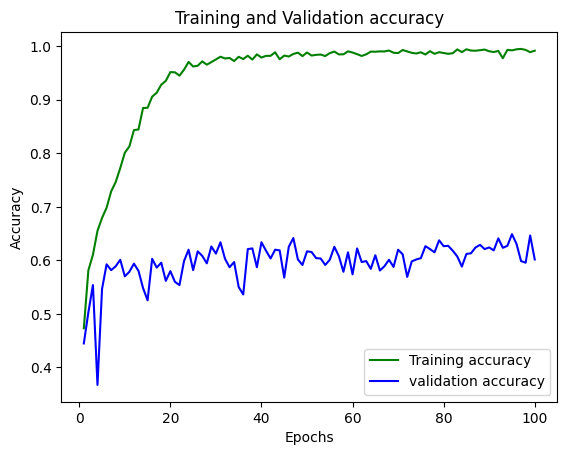

In [78]:
acc_train = history.history['accuracy']
acc_val = history.history['val_accuracy']

epochs = range(1,101)
plt.plot(epochs, acc_train, 'g', label='Training accuracy')
plt.plot(epochs, acc_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
#plt.savefig("accuracy.png")

In [80]:
model.save('.\\trained_model_mobileNet.h5')

In [81]:

predict=model.predict(aug.flow(test_data), batch_size=BS)
predict=np.argmax(predict,axis=1)
print(classification_report(test_labels.argmax(axis=1) ,predict, target_names=["0", "1", "2", "3", "4"]))

104/104 [==============================] - 3s 17ms/step
              precision    recall  f1-score   support

           0       0.38      0.37      0.38      1278
           1       0.17      0.24      0.20       592
           2       0.27      0.23      0.25       894
           3       0.13      0.11      0.12       446
           4       0.02      0.02      0.02       102

    accuracy                           0.26      3312
   macro avg       0.19      0.19      0.19      3312
weighted avg       0.27      0.26      0.27      3312



In [82]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
cm = confusion_matrix(y_true=test_labels.argmax(axis=1), y_pred=predict)

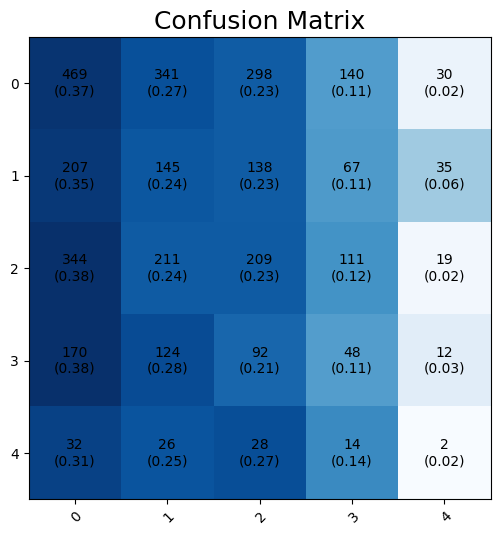

In [83]:
import matplotlib
fig, ax = plot_confusion_matrix(conf_mat=cm,
        figsize=(6, 6),
        class_names = ["0", "1","2","3","4"],
        show_absolute=True,
        show_normed=True,
         #cmap='Greys',

         norm_colormap=matplotlib.colors.LogNorm( ))

plt.xlabel('', fontsize=18)
plt.ylabel('', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
#plt.show()
plt.savefig("cm.png")
#print(ax)

In [ ]:
img = tf.keras.utils.load_img(
    "C:\\Users\\T-GAMER\\Downloads\\not_mask.png", target_size=(96, 96)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
img_array = preprocess_input(img_array)
mask, withoutMask=model.predict(img_array)[0]

            #determine the class label and color we will use to draw the bounding box and text
label, score =('Mask', mask) if mask>withoutMask else ('No Mask', withoutMask)
print((mask, withoutMask))
print(
    "This image most likely belongs to {} with a {} percent confidence."
    .format(label, score)
)


In [10]:
#teste de corte genérico
imagem = cv.imread("C:\\Users\\T-GAMER\\Downloads\\KneeXrayData\\KneeXrayData\\ClsKLData\kneeKL224\\val_preprocessed\\4\\9070207R.png", 0)
x,y = matchTemplatePrivate(imagem)
print(x)
print(y)
cv.imshow("image", imagem)
imagem = imagem[ x[1]:y[1],x[0]:y[0]]
print(imagem)
cv.imshow("image 2", imagem)
cv.waitKey(0)
cv.destroyAllWindows()

(11, 70)
(219, 155)
[[59 60 63 ... 33 33 32]
 [59 63 64 ... 35 33 30]
 [60 63 64 ... 35 32 31]
 ...
 [22 27 32 ...  5  5  5]
 [23 27 31 ...  5  5  5]
 [23 27 31 ...  6  5  4]]
